## Introduction:
The goal of this project is to establish a robust intelligent system to aid in value investing efforts using stock market data. The system will help make investment decisions and based on intrinsic value of companies. It will not, however, trade on the basis of daily market volatility. This project is a part 6 of a series of 7 companies. At the end of the project we will be able to:


1.   Predict stock price valuations on a daily, weekly and monthly basis
2.   Recommend to buy, sell or hold based on certain decision parameters
3.   Maximize capital returns, minimise loses, and minise hold periods

## Loading Libraries And Data For Brazil - Minerva SABrazil (BEEF)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
df = pd.read_excel('/content/2020Q1Q2Q3Q4-2021Q1.xlsx', sheet_name='Brazil - Minerva SABrazil (BEEF')

In [ ]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2021-03-31 00:00:00,10.2,10.35,10.4,10.12,7.77M,-0.0154
1,2021-03-30 00:00:00,10.36,10.41,10.62,10.3,9.93M,-0.0105
2,2021-03-29 00:00:00,10.47,9.85,10.5,9.81,22.04M,0.0651
3,2021-03-26 00:00:00,9.83,9.8,9.94,9.7,5.11M,0.0031
4,2021-03-25 00:00:00,9.8,10.01,10.01,9.66,8.88M,-0.0151


In [ ]:
df.shape

(310, 7)

## Data Wrangling

In [ ]:
df.tail()

,Date,Price,Open,High,Low,Vol.,Change %
305,2020-01-07 00:00:00,13.48,13.03,13.48,13.03,8.20M,0.0458
306,2020-01-06 00:00:00,12.89,12.9,12.91,12.57,4.17M,-0.0008
307,2020-01-03 00:00:00,12.9,12.45,12.93,12.27,4.88M,0.0263
308,2020-01-02 00:00:00,12.57,12.88,12.99,12.57,5.78M,-0.0210
309,Highest: 15.30,Lowest: 5.81,Difference: 9.49,Average: 11.38,Change %: -20.56,NaN,NaN


In [ ]:
df = df[:-1]

In [ ]:
df.dtypes

Date         object
Price        object
Open         object
High         object
Low          object
Vol.         object
Change %    float64
dtype: object

In [ ]:
df.isna().any()

Date        False
Price       False
Open        False
High        False
Low         False
Vol.        False
Change %    False
dtype: bool

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [ ]:
def convert_volume(x):
    if x.endswith('K'):
        return float(x[:-1]) * 1000
    elif x.endswith('M'):
        return float(x[:-1]) * 1000000
    else:
        return float(x)

In [ ]:
df['Vol.'] = df['Vol.'].apply(convert_volume)

In [ ]:
for i in df.columns:
  if df[i].dtype == 'object':
    df[i] = df[i].astype(float)

## Exploratory Data Analysis

In [ ]:
df['Price'].describe()

count    309.000000
mean      11.375890
std        1.889116
min        6.600000
25%        9.820000
50%       11.350000
75%       13.070000
max       15.220000
Name: Price, dtype: float64

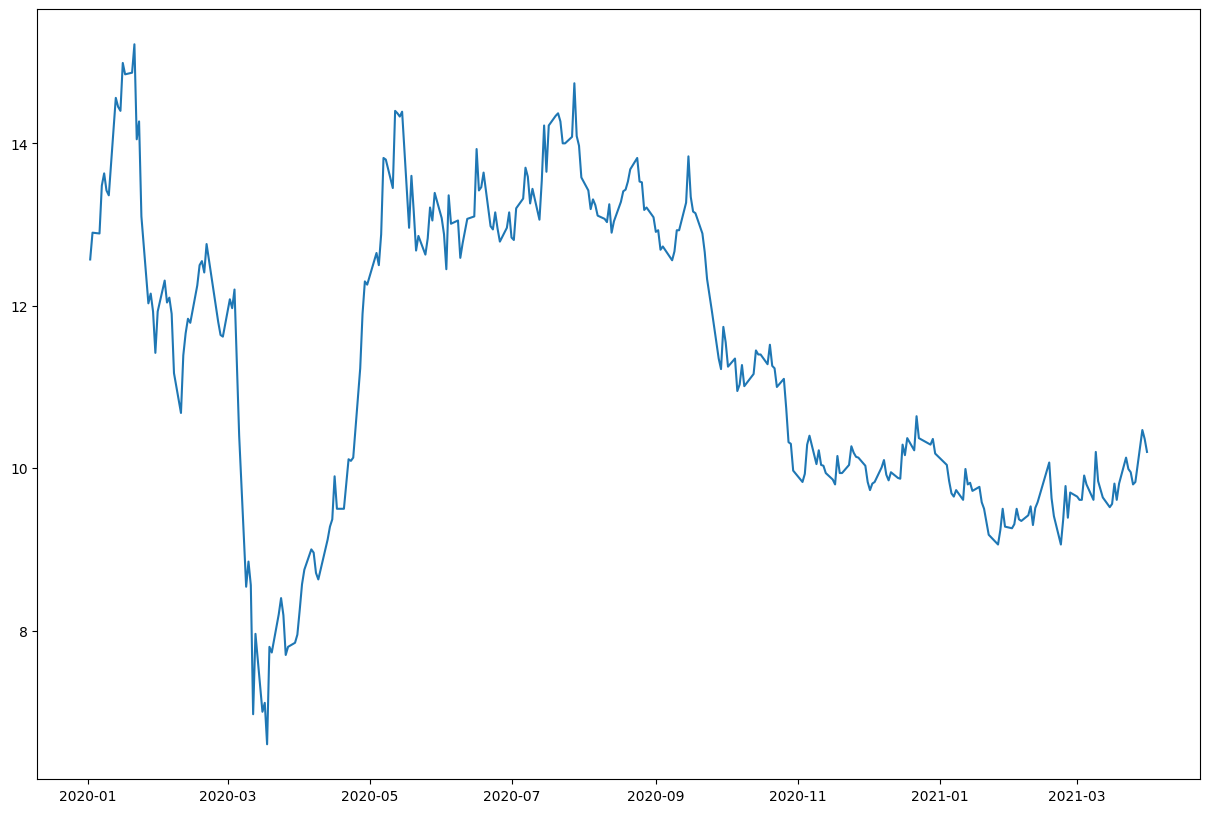

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(df['Price'])
plt.show()

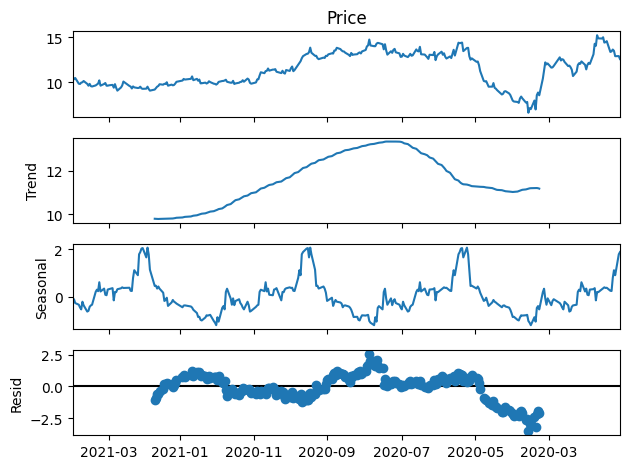

In [ ]:
decomp = seasonal_decompose(df['Price'], model='additive', period=90)
decomp.plot()
plt.show()

# Stationarity Check

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss
result = adfuller(df['Price'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:' )
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.204120
p-value: 0.204753
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572


In [ ]:
def stationarity_check(value):
  if value < 0.05:
    print(f'Data is Stationary')
  else:
    print(f'Data is Non-Stationary')
stationarity_check(result[1])

Data is Non-Stationary


In [ ]:
df['price_diff'] = df['Price'].diff()
df.dropna(inplace=True)

In [ ]:
df['rolling_mean_diff'] = df['price_diff'].rolling(window=5).mean()
df.dropna(inplace=True)

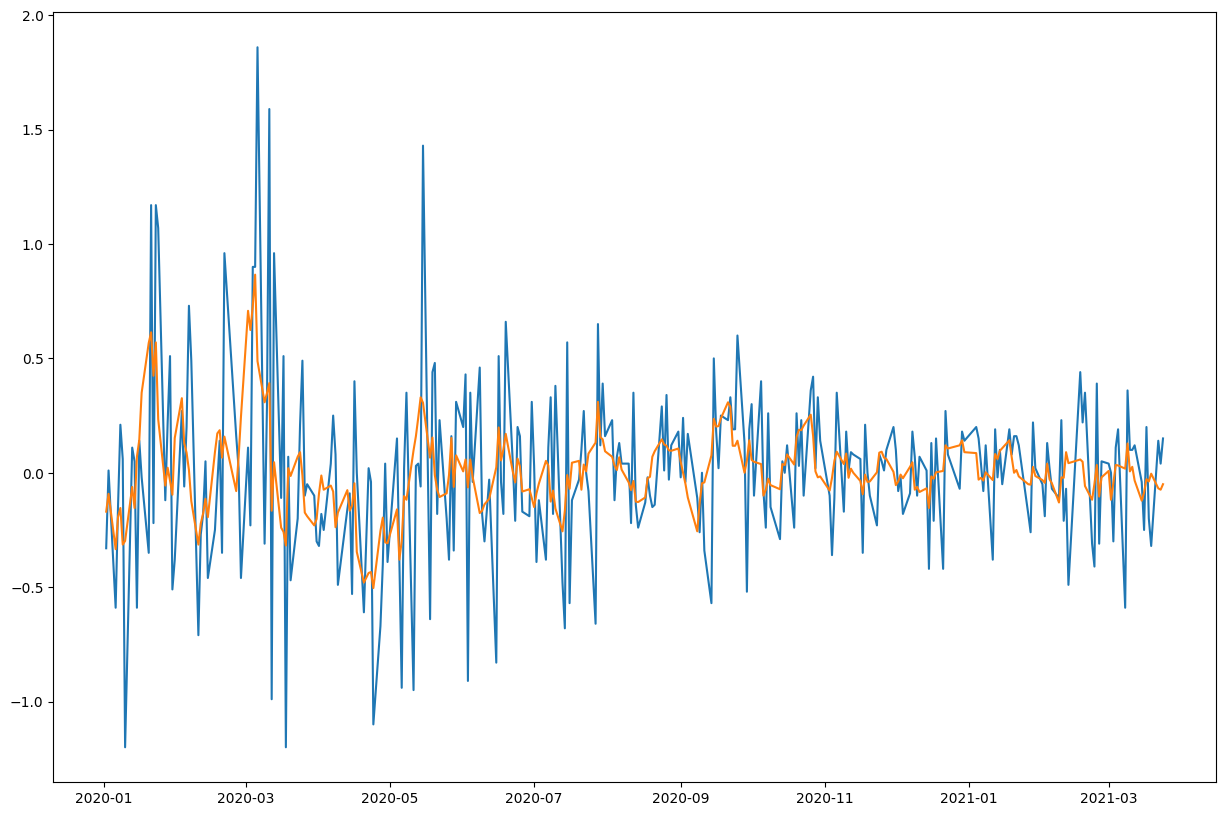

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(df['price_diff'])
plt.plot(df['rolling_mean_diff'])
plt.show()

## Modeling and Preprocessing

In [ ]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
df_train = df['2020-01-01':'2021-01-01']
df_test = df['2021-01-01':]


## Creating The ARIMA Model

In [ ]:
def evaluate_arima_model(data, arima_order):
  train, test = df_train['rolling_mean_diff'].values, df_test['rolling_mean_diff'].values
  past = [x for x in train]
  predictions = list()
  for t in range(len(test)):
    model = ARIMA(past, order=arima_order)
    model_fit = model.fit()
    future = model_fit.forecast()[0]
    predictions.append(future)
    past.append(test[t])
  error = mean_squared_error(test, predictions)
  return error

## Finding The Right Order For The ARIMA Model

In [ ]:
def evaluate_models(data, p_values, d_values, q_values):
  best_score, best_cfg = float("inf"), None
  for p in p_values:
    for d in d_values:
      for q in q_values:
        order = (p, q, d)
        try:
          mse = evaluate_arima_model(data, order)
          if mse < best_score:
            best_score, best_cfg = mse, order
          print('ARIMA%s MSE=%.3f' % (order, mse))
        except:
          continue
  return print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [ ]:
p_values = [x for x in range(0, 3)]
d_values = [x for x in range(0, 3)]
q_values = [x for x in range(0, 3)]

In [ ]:
#evaluate_models(df_train['rolling_mean_diff'].values, p_values, d_values, q_values)

In [ ]:
p = 1
d = 1
q = 1
model = ARIMA(df_train['rolling_mean_diff'], order=(p, d, q))
model_fit = model.fit()
forecast = model_fit.forecast(steps=len(df_test))

# Plotting The Fitted Model



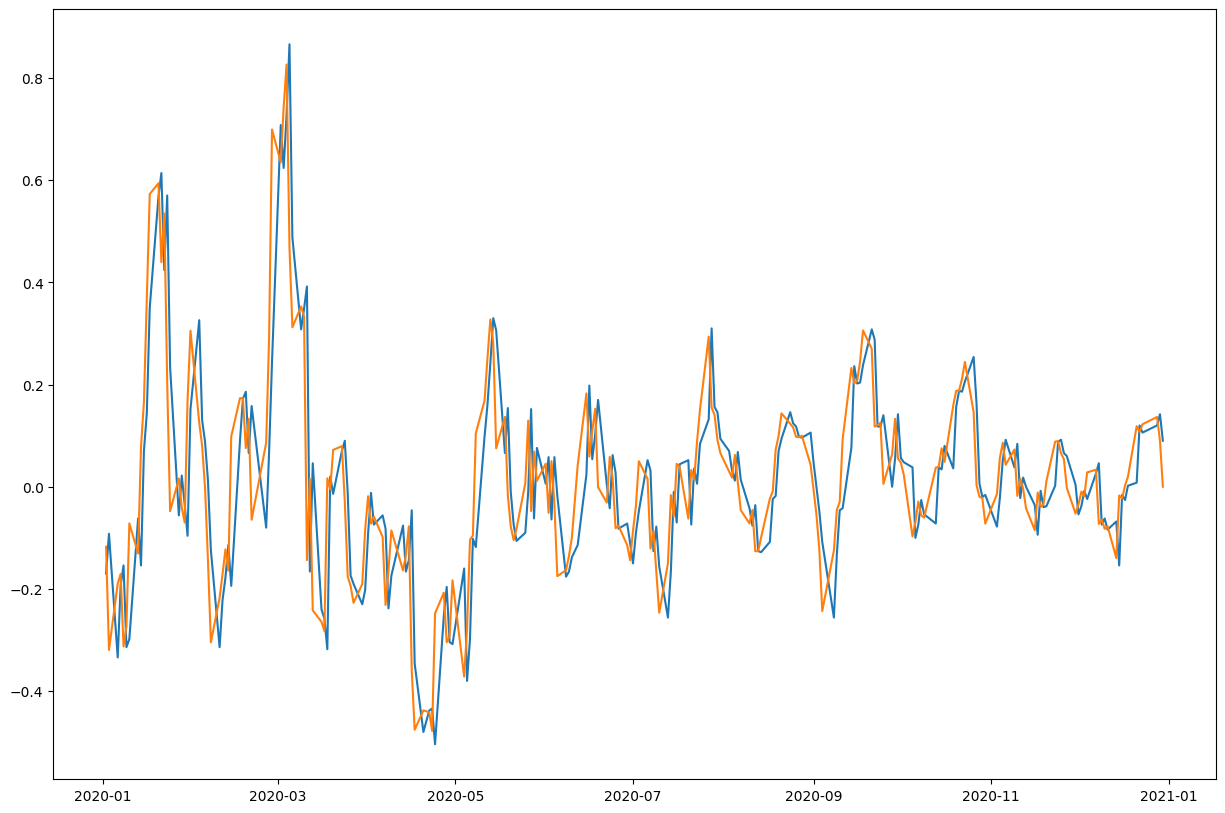

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(df_train['rolling_mean_diff'])
plt.plot(model_fit.predict())
plt.show()

In [ ]:
future_cast = model_fit.forecast(len(df_test))
future_cast.index = df_test.index
future_cast = pd.DataFrame(future_cast)
future_cast.columns = ['rolling_mean_diff']

# Plotting The Forecast



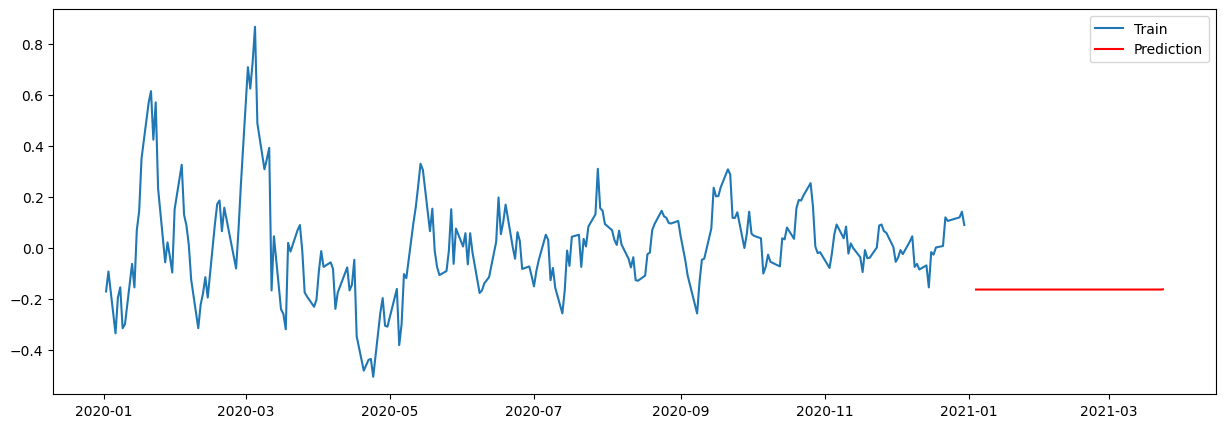

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(df_train['rolling_mean_diff'], label='Train')
plt.plot(future_cast['rolling_mean_diff'], color='red', label='Prediction')
plt.legend()
plt.show()

## Back Testing The Model

In [ ]:
def evaluate_arima_model(data, arima_order, start_train_size):
    history = list(data[:start_train_size])
    predictions = []
    for t in range(start_train_size, len(data)):

        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        future = model_fit.forecast(7)[-1]
        predictions.append(future)
        history.append(data[t])
    mse = mean_squared_error(data[start_train_size:], predictions)
    mae = mean_absolute_error(data[start_train_size:], predictions)

    return mse , mae, predictions


In [ ]:
mse, mae, predictions = evaluate_arima_model(df['rolling_mean_diff'].sort_index(), (1, 1, 1), len(df_train))

In [ ]:
forecast = pd.DataFrame(predictions)
forecast.columns = ['rolling_mean_diff']
forecast.index = df_test.index[::-1]
forecast.head()

,rolling_mean_diff
Date,
2021-01-04,0.094943
2021-01-05,0.086396
2021-01-06,-0.019040
2021-01-07,-0.022778
2021-01-08,-0.032866


In [ ]:
f_std = forecast['rolling_mean_diff'].std()

## Plotting The Forecast With Bollinger Bands

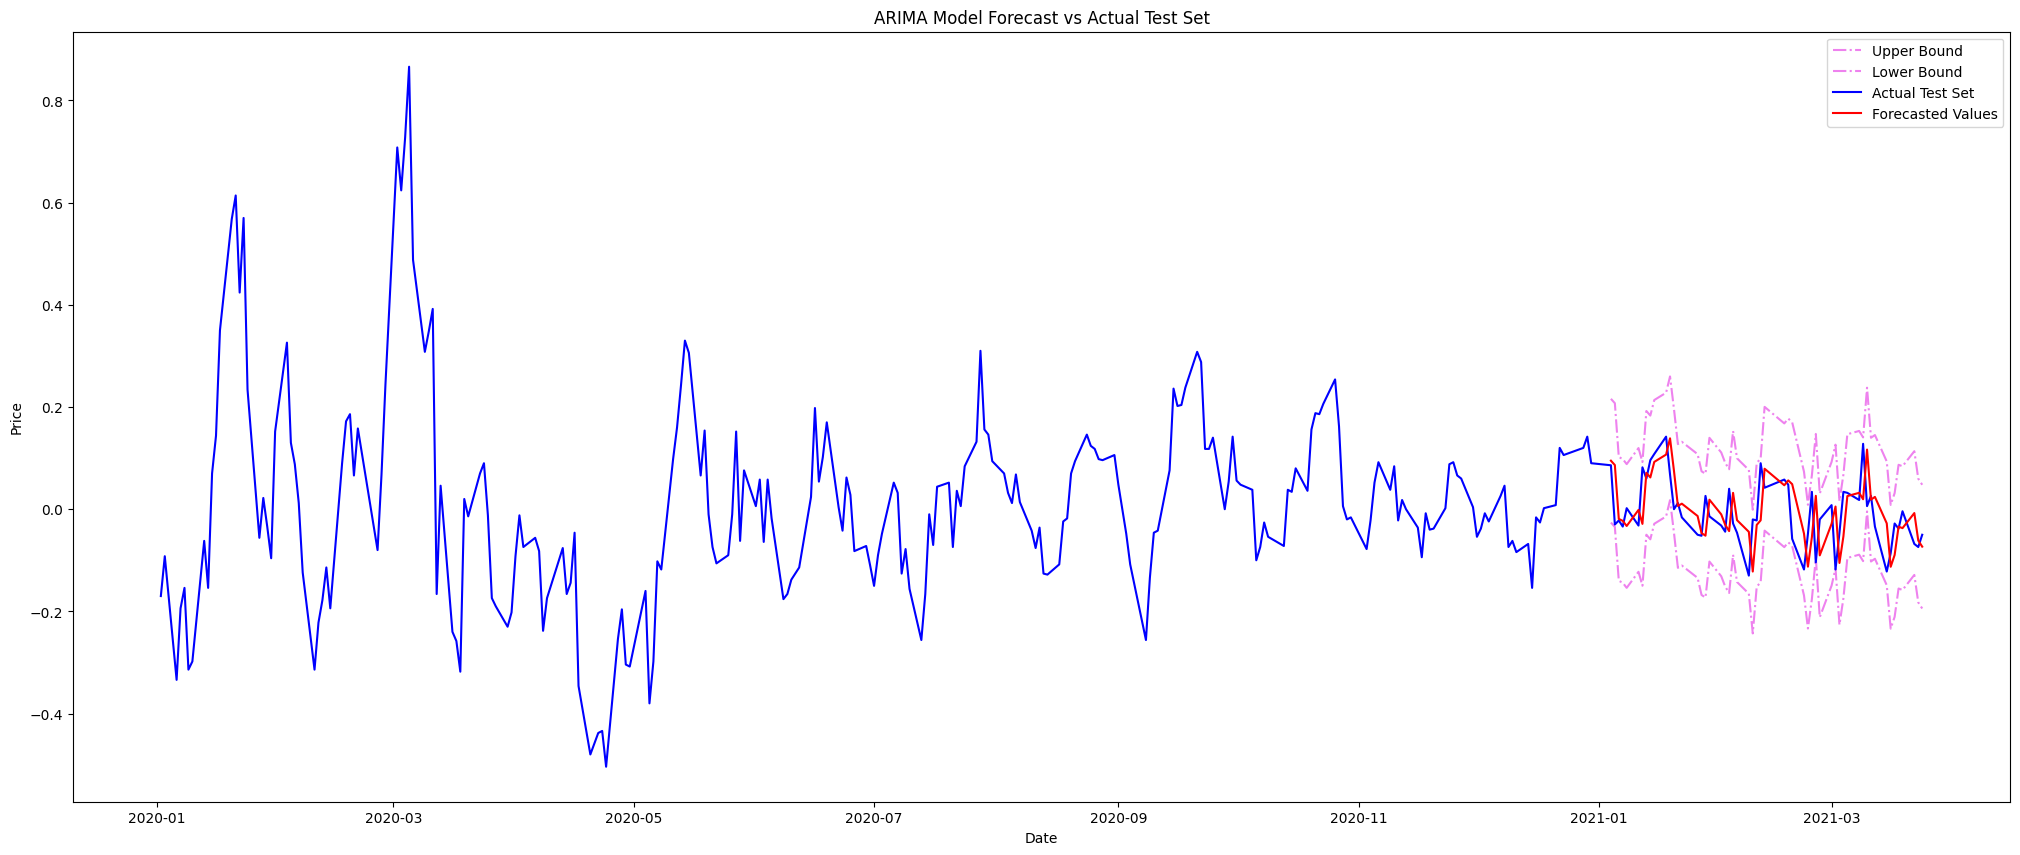

In [ ]:
plt.figure(figsize=(25,10))
plt.plot(forecast['rolling_mean_diff'] + 1.96*f_std, label='Upper Bound', color='violet', linestyle='-.')
plt.plot(forecast['rolling_mean_diff'] - 1.96*f_std, label='Lower Bound', color='violet', linestyle='-.')

plt.plot(df['rolling_mean_diff'], label='Actual Test Set', color='blue')

plt.plot(forecast, label='Forecasted Values', color='red')

plt.title('ARIMA Model Forecast vs Actual Test Set')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## Decisions: Buy, Hold, or Sell?

In [ ]:
o_std = df['rolling_mean_diff'].std()

In [ ]:
def buy_sell_hold(forecast, look_ahead, data, threshold=1.96):
  standard_dev = data['rolling_mean_diff'].std()
  decisions = []
  open_prices = []
  dates = []
  buy_sell_flag = 'buy'
  for i in range(len(forecast) - look_ahead):
    if standard_dev is None:
      return "Please provide standard deviation"
    else:
      open_prices.append(data['Open'].iloc[i])
      dates.append(forecast.index[i])
      if (forecast.iloc[i + look_ahead] > forecast.iloc[i] + threshold * standard_dev) & (buy_sell_flag != 'buy'):
        decisions.append('buy')
        buy_sell_flag = 'buy'
      elif (forecast.iloc[i + look_ahead] < forecast.iloc[i] - threshold * standard_dev) & (buy_sell_flag != 'sell'):
        decisions.append('sell')
        buy_sell_flag = 'sell'
      else:
        decisions.append('hold')
  df = pd.DataFrame({'Decision': decisions, 'Open': open_prices}, index=dates)
  return df

In [ ]:
decision_df = buy_sell_hold(forecast['rolling_mean_diff'], look_ahead=7, data=df, threshold=0.1)

In [ ]:
decision_df.head(30)

,Decision,Open
2021-01-04,sell,10.02
2021-01-05,hold,10.04
2021-01-06,buy,9.80
2021-01-07,hold,9.65
2021-01-08,hold,9.71
2021-01-11,hold,9.59
2021-01-12,hold,9.61
2021-01-13,sell,9.67
2021-01-14,hold,9.68
2021-01-15,hold,9.87


In [ ]:
def decision_score(lst):
  score = 0
  for i in range(len(lst)):
    if lst[i] == 'buy':
      score += 1
    elif lst[i] == 'sell':
      score -= 1
    else:
      score += 0
  return score

In [ ]:
decision_score(decision_df['Decision'])

-1